In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import re
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt



In [3]:
data = pd.read_csv('../data/FINAL_DATASET.csv')
data.set_index("id", inplace=True)
data.head()

,title,link,content,gold_label
id,,,,
0,ادارہ 'علم دوست' کی جانب سے'معلوماتِ عامہ' کے ...,https://www.express.pk/story/2733338/idara-ilm...,ادارہ 'علم دوست' کی جانب سے'معلوماتِ عامہ' کے ...,Entertainment
1,فلم ساز ودھو ونود چوپڑا کی نئی فلم ’زیرو سے ری...,https://www.express.pk/story/2733336/director-...,معروف فلم ساز ودھو ونود چوپڑا نے اپنی نئی فلم ...,Entertainment
2,عمر بڑھنے کے ساتھ وزن کم کرنا مشکل ہوتا ہے، اب...,https://www.express.pk/story/2733331/umer-barh...,ابھیشیک بچن نے اپنی نئی فلم ’آئی وانٹ ٹو ٹاک‘ ...,Entertainment
3,ملائکہ اروڑا والد کے انتقال کے بعد کام پر واپس...,https://www.express.pk/story/2733327/malaikaar...,مشہور اداکارہ ملائکہ اروڑا حال ہی میں والد کے ...,Entertainment
4,ڈائریکٹر دھرمیش درشن کا دو بار شاہ رخ خان کی ف...,https://www.express.pk/story/2733325/directord...,بالی ووڈ کے معروف ہدایتکار دھرمیش درشن نے حالی...,Entertainment


In [4]:
with open('../data/stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = file.read().splitlines()

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text

def normalize_unicode(text):
    return re.sub(r'[٠١٢٣٤٥٦٧٨٩]', '', text)  # Remove Urdu numerals

def normalize_urdu(text):
    text = re.sub(r'[؁؂؃؄؅؆؇؈؉؊؋،؛؟]', '', text)  # Remove Urdu punctuation
    text = re.sub(r'[آإأٱ]', 'ا', text)  # Normalize different forms of 'alif'
    text = re.sub(r'[ىېۍ]', 'ی', text)  # Normalize different forms of 'ye'
    text = re.sub(r'[ۀہ]', 'ہ', text)  # Normalize 'heh'
    text = re.sub(r'[ؤو]', 'و', text)  # Normalize 'waw'
    text = re.sub(r'[ءئ]', 'ی', text)  # Normalize 'hamza' with 'ye'
    return text

def tokenize_text(text):
    return re.findall(r'\w+', text)  # Extract words using regex

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords]

def lemmatize_custom(word):
    if word.endswith('نا') or word.endswith('تے'):
        return word[:-2]  # Strip suffix
    elif word.endswith('ا') or word.endswith('ی'):
        return word[:-1]  # Remove singular/plural suffix
    return word

def lemmatize_text(tokens):
    return [lemmatize_custom(word) for word in tokens]

def remove_non_informative_words(tokens):
    return [word for word in tokens if len(word) > 1]  # Remove single-character tokens


def preprocess_urdu_text(text):
    text = clean_text(text)  # Clean text
    text = normalize_unicode(text)  # Normalize Unicode
    text = normalize_urdu(text)  # Normalize Urdu-specific characters
    tokens = tokenize_text(text)  # Tokenize text
    tokens = remove_stopwords(tokens)  # Remove stopwords
    tokens = lemmatize_text(tokens)
    tokens = remove_non_informative_words(tokens)# Apply lemmatization
    return ' '.join(tokens)  # Return preprocessed text

# Apply preprocessing to dataset
data['title'] = data['title'].apply(preprocess_urdu_text)
data['content'] = data['content'].apply(preprocess_urdu_text)
data['combined'] = data['title'] + " " + data['content']


In [5]:
train_data, test_val_data = train_test_split(data, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(test_val_data, test_size=0.5, random_state=42)

In [6]:
MAX_VOCAB = 6000
word_counter = Counter(" ".join(train_data["content"]).split())
vocab = [word for word, freq in word_counter.most_common(MAX_VOCAB)]
word_to_idx = {word: idx for idx, word in enumerate(vocab)}


In [ ]:
def vectorize_text(text, vocab, word_to_idx):
    vector = np.zeros(len(vocab))
    for word in text.split():
        if word in word_to_idx:
            vector[word_to_idx[word]] += 1
    return vector

class MinMaxNormalizer:
    def __init__(self):
        self.min = None
        self.max = None

    def fit(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)

    def transform(self, data):
        return (data - self.min) / (self.max - self.min)

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)


train_vectors = np.array([vectorize_text(text, vocab, word_to_idx) for text in train_data["content"]])
val_vectors = np.array([vectorize_text(text, vocab, word_to_idx) for text in val_data["content"]])
test_vectors = np.array([vectorize_text(text, vocab, word_to_idx) for text in test_data["content"]])

# # Normalize the vectors - LOOK INTO THIS
# normalizer = MinMaxNormalizer()
# train_vectors = normalizer.fit_transform(train_vectors)
# val_vectors = normalizer.transform(val_vectors)
# test_vectors = normalizer.transform(test_vectors)
    
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data["gold_label"])
val_labels = label_encoder.transform(val_data["gold_label"])
test_labels = label_encoder.transform(test_data["gold_label"])


In [10]:
class RegularizedLogisticRegression:
    def __init__(self, alpha, lambda_val, n_iterations):
        self.alpha = alpha
        self.lambda_val = lambda_val
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
    
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))
    
    def cross_entropy_loss(self,y_true,y_pred):
        m = len(y_true)
        ce_loss = -np.mean((y_true * np.log(y_pred)) + ((1 - y_true) * np.log(1 - y_pred)))
        regularisation_cost = (self.lambda_val / (2 * m)) * np.sum(self.weights ** 2)
        return ce_loss + regularisation_cost
    
    def fit(self, x_train, y_train):
        m, n = x_train.shape
        self.weights = np.zeros(n)
        self.bias = 0
        loss_values = []

        for i in range(self.n_iterations):
            
            y_predicted = self.sigmoid((x_train @ self.weights.T) + self.bias)
            
            weights_gradient = ((1 / m) * np.dot(x_train.T, (y_predicted - y_train))) + ((1 / m) * self.lambda_val * self.weights)
            bias_gradient = (1 / m) * np.sum(y_predicted - y_train)

            self.weights = self.weights - (self.alpha * weights_gradient)
            self.bias = self.bias - (self.alpha * bias_gradient)
            
            loss = self.cross_entropy_loss(y_train, y_predicted)
            loss_values.append(loss)
        
        return loss_values
            
    def predict(self, x_test):
        probability = self.sigmoid((x_test @ self.weights.T) + self.bias)
        label = [1 if p >= 0.5 else 0 for p in probability]
        return label, probability
    
    def evaluate(self, y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        
        return acc, f1, cm
    

In [ ]:
lambda_vals = [0.01, 0.1, 1, 10]

optimal_lambda = None
optimal_acc = 0
for lambda_val in lambda_vals:
    all_probs = []
    multi_class_pred = []
    for i in range(label_encoder.classes_.shape[0]):
        y_binary = (train_labels == i).astype(int) 
        model = RegularizedLogisticRegression(alpha=0.01,lambda_val=lambda_val,n_iterations=30000) 
        model.fit(train_vectors,y_binary)
        all_probs.append(model.predict(val_vectors)[1])
    
    for i in range(len(val_labels)):
        probs = [p[i] for p in all_probs]
        softmax_sum = np.sum(np.exp(probs))
        softmax_probs = np.exp(probs) / softmax_sum
        max_prob = np.argmax(softmax_probs)
        multi_class_pred.append(max_prob)
        
    accuracy = accuracy_score(val_labels, multi_class_pred)
    f1 = f1_score(val_labels, multi_class_pred, average='macro')
    
    print(f"Lambda: {lambda_val}, Accuracy: {accuracy}, F1 Score: {f1}")
    if accuracy > optimal_acc:
        optimal_acc = accuracy
        optimal_lambda = lambda_val
    

Lambda: 0.001, Accuracy: 0.954233409610984, F1 Score: 0.9491589016991071
Lambda: 0.01, Accuracy: 0.954233409610984, F1 Score: 0.9491589016991071
Lambda: 0.1, Accuracy: 0.954233409610984, F1 Score: 0.9491589016991071
Lambda: 1, Accuracy: 0.954233409610984, F1 Score: 0.9491589016991071
Lambda: 10, Accuracy: 0.9519450800915332, F1 Score: 0.9463118844743098


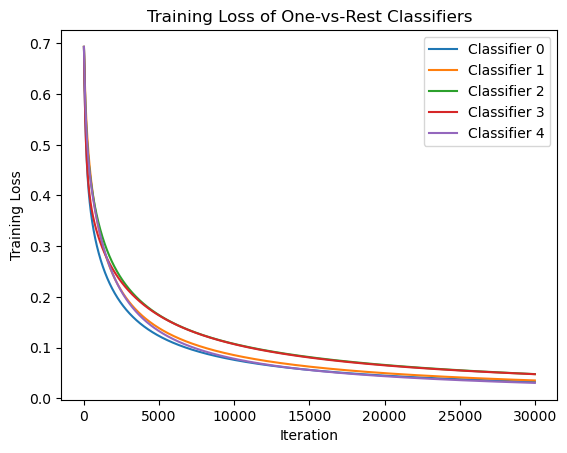

In [ ]:
classifiers = {}
losses = {}  
for i in range(label_encoder.classes_.shape[0]):
    y_binary = (train_labels == i).astype(int) 
    classifiers[i] = RegularizedLogisticRegression(0.01,optimal_lambda,30000) 
    cost = classifiers[i].fit(train_vectors,y_binary)
    losses[i] = cost 

for i in range(label_encoder.classes_.shape[0]):
    plt.plot(losses[i], label=f"Classifier {i}")

plt.title("Training Loss of One-vs-Rest Classifiers")
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

In [46]:
# Evaluate each binary classifier
results = {
    'Class': [],
    'Probs':[],
    'Accuracy': [],
    'F1 Score': [],
    'Confusion Matrix': []
}

for i in range(label_encoder.classes_.shape[0]):  
    predicted_class, probability =  classifiers[i].predict(test_vectors)  
    y_binary = (test_labels == i).astype(int)
    accuracy, f1, cm = classifiers[i].evaluate(y_binary, predicted_class)
    
    results['Class'].append(i)
    results['Probs'].append(probability)
    results['Accuracy'].append(accuracy)
    results['F1 Score'].append(f1)
    results['Confusion Matrix'].append(cm)

results_df = pd.DataFrame(results)

In [47]:
multi_class_pred = []
multi_class_labels = []
for i in range(len(test_labels)):
    probs = np.array([results_df["Probs"][0][i],results_df["Probs"][1][i],results_df["Probs"][2][i],results_df["Probs"][3][i],results_df["Probs"][4][i]])
    softmax_sum = np.sum(np.exp(probs))
    softmax_probs = np.exp(probs) / softmax_sum
    max_prob = np.argmax(softmax_probs)
    multi_class_pred.append(max_prob)


In [48]:
accuracy = accuracy_score(test_labels, multi_class_pred)
f1 = f1_score(test_labels, multi_class_pred, average='macro')
cm = confusion_matrix(test_labels, multi_class_pred)
precision = precision_score(test_labels, multi_class_pred, average='macro')
recall = recall_score(test_labels, multi_class_pred, average='macro')
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)

Accuracy: 0.9725400457665904
F1 Score: 0.9733697209898858
Precision: 0.9739326433905007
Recall: 0.9729665940450255
Confusion Matrix:
 [[ 80   0   0   0   1]
 [  0  84   0   0   0]
 [  0   2  92   0   2]
 [  0   0   3  65   0]
 [  1   0   2   1 104]]
